In [30]:
# Random Forest Classifier from Scratch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import Counter

# Set random seed for reproducible results across multiple runs
np.random.seed(42)

In [31]:
# Node Class: Represents a single node in the decision tree
# This class stores all the information needed for each node in our tree structure

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # feature_index: Which feature (column) to split on at this node
        self.feature_index = feature_index
        
        # threshold: The value to compare the feature against for splitting
        self.threshold = threshold
        
        # left: Reference to the left child node (samples <= threshold)
        self.left = left
        
        # right: Reference to the right child node (samples > threshold)
        self.right = right
        
        # info_gain: How much information gain this split provides
        self.info_gain = info_gain
        
        # value: The predicted class for leaf nodes (None for internal nodes)
        self.value = value

In [32]:
# Decision Tree Class: Modified for Random Forest with Feature Randomness
# This is a single decision tree that will be used as a component in our Random Forest

class DecisionTreeForRF():
    def __init__(self, min_sample_split=2, max_depth=10, criterion="entropy", max_features=None):
        # root: The top node of our decision tree
        self.root = None
        
        # min_sample_split: Minimum samples required to split a node (prevents overfitting)
        self.min_sample_split = min_sample_split
        
        # max_depth: Maximum depth of the tree (prevents overfitting)
        self.max_depth = max_depth
        
        # criterion: How to measure the quality of a split ("entropy" or "gini")
        self.criterion = criterion
        
        # max_features: Number of features to consider at each split (key for Random Forest)
        self.max_features = max_features
    
    def fit(self, X, y):
        """Train the decision tree on the given data"""
        # Store the total number of features in the dataset
        self.n_features = X.shape[1]
        
        # If max_features not specified, use square root of total features (common for classification)
        if self.max_features is None:
            self.max_features = int(np.sqrt(self.n_features))

        # Combine features and labels into one dataset for easier handling
        dataset = np.concatenate((X, y.reshape(-1,1)), axis=1)
        
        # Start building the tree from the root
        self.root = self.build_tree(dataset)

    def build_tree(self, dataset: np.ndarray, curr_depth=0):
        """Recursively build the decision tree using the dataset"""
        # Separate features (X) and labels (y) from the combined dataset
        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = X.shape

        # Check stopping criteria for tree growth
        if num_samples >= self.min_sample_split and curr_depth <= self.max_depth:
            # Try to find the best possible split for this node
            best_split = self.get_best_split(dataset, num_samples, num_features)

            # If we found a good split (positive information gain)
            if best_split.get("info_gain", 0) > 0:
                # Recursively build left subtree with samples that go left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                
                # Recursively build right subtree with samples that go right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                # Create internal node with the best split information
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
            
        # If stopping criteria met or no good split found, create a leaf node
        leaf_node = self.leaf_node(y)
        return Node(value=leaf_node)
    
    def get_best_split(self, dataset, num_samples, num_features):
        """Find the best feature and threshold to split on using RANDOM FEATURES (key RF modification)"""
        best_split = {}
        max_info_gain = -float("inf")

        # RANDOM FOREST KEY FEATURE: Randomly select subset of features to consider
        # This creates diversity between trees in the forest
        available_features = list(range(num_features))
        selected_features = np.random.choice(available_features, 
                                           size=min(self.max_features, num_features), 
                                           replace=False)

        # Try only the randomly selected features (not all features)
        for feature_index in selected_features:
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # Try different threshold values for this feature
            for i in range(1, len(possible_thresholds)):
                # Calculate threshold as midpoint between consecutive unique values
                threshold = (possible_thresholds[i] + possible_thresholds[i-1]) / 2
                
                # Split the dataset based on this threshold
                dataset_left, dataset_right = self.split(feature_index, dataset, threshold)

                # Only consider splits that create non-empty subsets
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, y_left, y_right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    # Calculate how much information gain this split provides
                    curr_info_gain = self.information_gain(y, y_left, y_right, self.criterion)

                    # Keep track of the best split found so far
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        
        return best_split

    def split(self, feature_index, dataset, threshold):
        """Split the dataset based on a feature and threshold"""
        # Left split: samples where feature value <= threshold
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        
        # Right split: samples where feature value > threshold
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        
        return dataset_left, dataset_right

    def information_gain(self, parent, left_child, right_child, criterion):
        """Calculate the information gain from a split"""
        # Calculate weights based on the size of each child
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)

        # Calculate information gain using the specified criterion
        if criterion == "entropy":
            # Information Gain = Parent Entropy - Weighted Average of Child Entropies
            info_gain_val = self.entropy(parent) - (weight_left * self.entropy(left_child) + weight_right * self.entropy(right_child))
        elif criterion == "gini":
            # Information Gain = Parent Gini - Weighted Average of Child Gini
            info_gain_val = self.gini(parent) - (weight_left * self.gini(left_child) + weight_right * self.gini(right_child))
        return info_gain_val
        
    def entropy(self, y):
        """Calculate entropy (measure of disorder/impurity) of a dataset"""
        entropy_val = 0
        class_labels = np.unique(y)
        
        # Entropy = -Σ(p_i * log2(p_i)) where p_i is probability of class i
        for _class in class_labels:
            prob_class = len(y[y == _class]) / len(y)
            entropy_val += -prob_class * np.log2(prob_class)
        return entropy_val
        
    def gini(self, y):
        """Calculate Gini impurity (alternative to entropy) of a dataset"""
        gini_val = 1
        class_labels = np.unique(y)
        
        # Gini = 1 - Σ(p_i^2) where p_i is probability of class i
        for _class in class_labels:
            prob_class = len(y[y==_class]) / len(y)
            gini_val -= prob_class ** 2
        return gini_val

    def leaf_node(self, y):
        """Create a leaf node by finding the most common class in the data"""
        unique_classes, counts = np.unique(y, return_counts=True)
        # Return the class with the highest count (majority vote)
        return unique_classes[np.argmax(counts)]
    
    def make_predictions(self, X, tree):
        """Recursively traverse the tree to make a prediction for a single sample"""
        # If we reached a leaf node, return its prediction
        if tree.value is not None:
            return tree.value
        
        # Get the feature value for the current node's feature
        feature_val = X[tree.feature_index]
        
        # Decide which direction to go based on the threshold
        if feature_val <= tree.threshold:
            return self.make_predictions(X, tree.left)  # Go left
        else:
            return self.make_predictions(X, tree.right)  # Go right
        
    def predict(self, X):
        """Make predictions for all samples in X"""
        predictions = []
        # Make prediction for each sample individually
        for data_point in X:
            prediction = self.make_predictions(data_point, self.root)
            predictions.append(prediction)
        return np.array(predictions)

In [33]:
# Bootstrap Sampling Function: Creates diverse training sets for each tree
# This is a key component of Random Forest that introduces randomness in the data

def bootstrap_sample(X, y):
    """
    Create a bootstrap sample (random sample with replacement) from the training data.
    
    Bootstrap sampling allows some samples to appear multiple times and others to be left out,
    creating different training sets for each tree in the forest.
    
    Args:
        X: Feature matrix
        y: Target labels
    
    Returns:
        X_bootstrap, y_bootstrap: Bootstrap sample of the same size as original data
    """
    # Get the number of samples in the original dataset
    n_samples = X.shape[0]
    
    # Randomly select indices WITH replacement (key: replace=True)
    # This means some samples may appear multiple times, others may not appear at all
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    
    # Return the bootstrap sample using the selected indices
    return X[indices], y[indices]

In [34]:
# Random Forest Class: Ensemble of Decision Trees with Voting
# Combines multiple decision trees to create a more robust and accurate model

class RandomForest():
    def __init__(self, n_estimators=100, max_depth=10, min_sample_split=2,
                 max_features=None, criterion="entropy", random_state=None):
        """
        Initialize Random Forest Classifier
        
        Args:
            n_estimators: Number of decision trees in the forest
            max_depth: Maximum depth of each individual tree
            min_sample_split: Minimum samples required to split a node
            max_features: Number of features to consider at each split
            criterion: Splitting criterion ("entropy" or "gini")
            random_state: Random seed for reproducible results
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.max_features = max_features
        self.criterion = criterion
        self.random_state = random_state

        # List to store all the trained decision trees
        self.trees = []

    def fit(self, X, y):
        """
        Train the Random Forest by creating and training multiple decision trees
        
        Each tree is trained on a different bootstrap sample of the data,
        ensuring diversity in the forest.
        """
        # Set random seed for reproducible results
        if self.random_state:
            np.random.seed(self.random_state)

        # Reset trees list (important for retraining)
        self.trees = []

        # Train each tree in the forest
        for i in range(self.n_estimators):
            # Step 1: Create a bootstrap sample (random sample with replacement)
            X_bootstrap, y_bootstrap = bootstrap_sample(X, y)

            # Step 2: Create a new decision tree with the specified parameters
            tree = DecisionTreeForRF(min_sample_split=self.min_sample_split,
                                     max_depth=self.max_depth,
                                     criterion=self.criterion,
                                     max_features=self.max_features
                                     )
            
            # Step 3: Train the tree on the bootstrap sample
            tree.fit(X_bootstrap, y_bootstrap)

            # Step 4: Add the trained tree to our forest
            self.trees.append(tree)

            # Progress indicator (print every 20 trees or the first tree)
            if (i + 1) % 20 == 0 or i == 0:
                print(f"Trained {i + 1}/{self.n_estimators} trees")
        
        return self  # Return self for method chaining

    def predict(self, X):
        """
        Make predictions using majority voting from all trees in the forest
        
        Each tree votes for a class, and the final prediction is the class
        that receives the most votes.
        """
        # Collect predictions from all trees
        tree_predictions = []

        # Get prediction from each tree in the forest
        for tree in self.trees:
            pred = tree.predict(X)
            tree_predictions.append(pred)

        # Convert to numpy array for easier manipulation
        # Shape: (n_trees, n_samples)
        tree_predictions = np.array(tree_predictions)

        # Perform majority voting for each sample
        final_predictions = []
        for i in range(X.shape[0]):  # For each test sample
            # Get all tree predictions for this sample
            sample_predictions = tree_predictions[:, i]

            # Count votes for each class
            vote_counts = Counter(sample_predictions)
            
            # Get the class with the most votes (majority vote)
            majority_vote = vote_counts.most_common(1)[0][0]
            final_predictions.append(majority_vote)

        return np.array(final_predictions)
    
    def predict_proba(self, X):
        """
        Get class probabilities by calculating the proportion of votes for each class
        
        Instead of just returning the majority vote, this returns the probability
        of each class based on the proportion of trees that voted for it.
        """
        # Collect predictions from all trees
        tree_predictions = []

        # Get prediction from each tree in the forest
        for tree in self.trees:
            pred = tree.predict(X)
            tree_predictions.append(pred)

        # Convert to numpy array: Shape (n_trees, n_samples)
        tree_predictions = np.array(tree_predictions)

        # Calculate probabilities for each sample
        probabilities = []
        for i in range(X.shape[0]):  # For each test sample
            # Get all tree predictions for this sample
            sample_predictions = tree_predictions[:, i]

            # Count votes for each class
            vote_counts = Counter(sample_predictions)
            total_votes = len(sample_predictions)

            # Calculate probability for each unique class
            prob_list = []
            for cls in np.unique(tree_predictions):
                prob = vote_counts[cls] / total_votes
                prob_list.append(prob)
            
            probabilities.append(prob_list)
        return np.array(probabilities)

In [35]:
# Load the Breast Cancer Dataset
# This dataset contains features of cell nuclei from breast cancer biopsies
# Goal: Predict whether a tumor is Malignant (M) or Benign (B)

# Load the CSV file containing the breast cancer data
data = pd.read_csv("Datasets\data.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [36]:
# Data Preprocessing: Prepare features and target variable
# Separate the features from the target variable and encode the labels

# Features (X): All columns except 'diagnosis' and 'id'
# Remove 'diagnosis' (target) and 'id' (irrelevant identifier) columns
X = data.drop(columns=['diagnosis', 'id']).values  

# Target variable (y): Encode diagnosis as numerical values
# Convert M (Malignant) to 1 and B (Benign) to 0 for binary classification
# Reshape to column vector for compatibility with our algorithms
y = data['diagnosis'].map({'M': 1, 'B': 0}).values

# Split the dataset into training and testing sets
# 80% for training, 20% for testing, with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes to verify the split worked correctly
print(f"Training set shapes: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shapes: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Total features: {X_train.shape[1]}")
print(f"Total training samples: {X_train.shape[0]}")
print(f"Total testing samples: {X_test.shape[0]}")

Training set shapes: X_train=(455, 30), y_train=(455,)
Testing set shapes: X_test=(114, 30), y_test=(114,)
Total features: 30
Total training samples: 455
Total testing samples: 114


Training set distribution:
Benign samples: 286 (62.9%)
Malignant samples: 169 (37.1%)


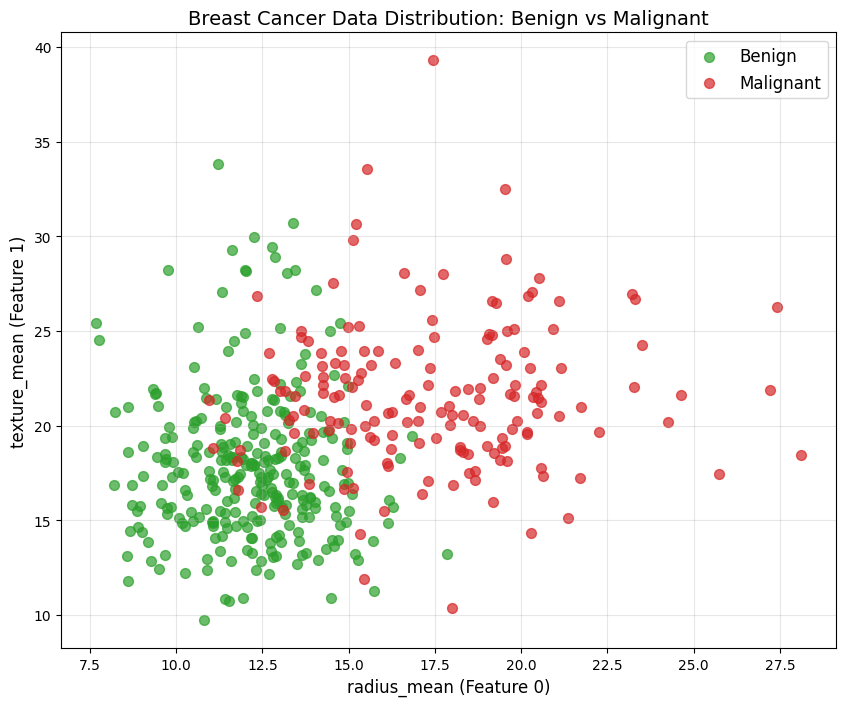

In [39]:
# Data Visualization: Plot the distribution of Benign vs Malignant tumors
# Visualize the first two features (radius_mean and texture_mean) to understand data distribution

# Extract data points for visualization from the training set
# Get all benign (B=0) tumor data points from training set
benign_points = X_train[y_train == 0]

# Get all malignant (M=1) tumor data points from training set  
malignant_points = X_train[y_train == 1]

# Create a scatter plot to visualize the data distribution
plt.figure(figsize=(10, 8))

# Plot benign tumors in green (typically smaller radius and different texture)
plt.scatter(benign_points[:, 0], benign_points[:, 1], 
           color="tab:green", label="Benign", alpha=0.7, s=50)

# Plot malignant tumors in red (typically larger radius and different texture)
plt.scatter(malignant_points[:, 0], malignant_points[:, 1], 
           color="tab:red", label="Malignant", alpha=0.7, s=50)

# Add axis labels (using first two features from the dataset)
plt.xlabel("radius_mean (Feature 0)", fontsize=12)
plt.ylabel("texture_mean (Feature 1)", fontsize=12)
plt.title("Breast Cancer Data Distribution: Benign vs Malignant", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add some statistics to the plot
print(f"Training set distribution:")
print(f"Benign samples: {len(benign_points)} ({len(benign_points)/len(y_train)*100:.1f}%)")
print(f"Malignant samples: {len(malignant_points)} ({len(malignant_points)/len(y_train)*100:.1f}%)")

plt.show()

In [38]:
# Train Our Custom Random Forest Model
# Create and train a Random Forest with specified hyperparameters

# Initialize Random Forest with carefully chosen parameters
rf = RandomForest(
    n_estimators=100,       # Use 100 decision trees in the forest
    max_depth=10,           # Limit tree depth to prevent overfitting
    min_sample_split=2,     # Minimum samples required to split a node
    criterion="gini",       # Use entropy for measuring split quality
    random_state=34         # Set seed for reproducible results
)

# Train the model and immediately make predictions (method chaining)
# This demonstrates the fit() method returning self for chaining
print("="*50)
print("TRAINING CUSTOM RANDOM FOREST")
print("="*50)

y_pred = rf.fit(X_train, y_train).predict(X_test)

print("="*50)
print("TRAINING COMPLETED - PREDICTIONS MADE")
print("="*50)

TRAINING CUSTOM RANDOM FOREST
Trained 1/100 trees
Trained 20/100 trees
Trained 40/100 trees
Trained 60/100 trees
Trained 80/100 trees
Trained 100/100 trees
TRAINING COMPLETED - PREDICTIONS MADE


In [ ]:
print("="*50)
print("CUSTOM RANDOM FOREST PERFORMANCE METRICS")
print("="*50)
# Evaluate the model's performance using various metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("="*50)

CUSTOM RANDOM FOREST PERFORMANCE METRICS
Confusion Matrix:
[[70  1]
 [ 3 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 96.49%


In [ ]:
# Compare with Scikit-Learn's Random Forest Implementation
# Train sklearn's optimized Random Forest for performance comparison

print("="*60)
print("TRAINING SCIKIT-LEARN RANDOM FOREST FOR COMPARISON")
print("="*60)

# Import sklearn's Random Forest implementation
from sklearn.ensemble import RandomForestClassifier

# Create sklearn Random Forest with similar parameters to our custom implementation
sklearn_rf = RandomForestClassifier(
    n_estimators=100,       # Same number of trees as our custom RF
    max_depth=10,          # Same maximum depth
    random_state=42        # Same random seed for fair comparison
    # Note: sklearn uses different default values for min_samples_split and max_features
)

# Train the sklearn model
# Note: sklearn expects 1D array for y, so we use ravel() to flatten
sklearn_rf.fit(X_train, y_train.ravel())

# Make predictions using the trained sklearn model
sklearn_predictions = sklearn_rf.predict(X_test)
print("scikit-learn Random Forest Predictions Completed")

TRAINING SCIKIT-LEARN RANDOM FOREST FOR COMPARISON
scikit-learn Random Forest Predictions Completed


In [ ]:
print("="*50)
print("SCIKIT-LEARN RANDOM FOREST PERFORMANCE METRICS")
print("="*50)
# Evaluate sklearn model's performance using the same metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, sklearn_predictions))
print("\nClassification Report:")
print(classification_report(y_test, sklearn_predictions))
print(f"Accuracy: {accuracy_score(y_test, sklearn_predictions)*100:.2f}%")


SCIKIT-LEARN RANDOM FOREST PERFORMANCE METRICS
Confusion Matrix:
[[70  1]
 [ 3 40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Accuracy: 96.49%
